In [1]:
from ROOT import TMVA, TFile, TTree, TCut, TString
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Concatenate, Dense, LSTM, Input, concatenate, SimpleRNN, GRU, Masking, Lambda, Reshape, Dropout, RNN
from tensorflow.keras.optimizers import Adagrad, SGD, RMSprop, Adam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from IPython.display import display
import graphviz
from numba import cuda
from array import array
import pickle
import scikitplot as skplt
import seaborn as sns

Welcome to JupyROOT 6.19/01


Load signal and background trees

In [2]:
signalFile=TFile.Open("samples/sig_nonres_bbtt.root")
backgroundFile=TFile.Open("samples/bkg_ttbar_dilepton.root")

In [3]:
signalTree=signalFile.Get("ntup")
backgroundTree=backgroundFile.Get("ntup")

In [4]:
signalNum=signalTree.GetEntries()
backgroundNum=backgroundTree.GetEntries()
print("signal events number before cut is: ",signalNum)
print("background events number before cut is: ",backgroundNum)

signal events number before cut is:  217248
background events number before cut is:  10995


Convert minitree into numpy

In [5]:
signalArray=signalTree.AsMatrix(["weight","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
backgroundArray=backgroundTree.AsMatrix(["weight","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
print(signalArray.shape)

(217248, 22)


In [6]:
dataSignal=pd.DataFrame(data=signalArray[:,1:],columns=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])

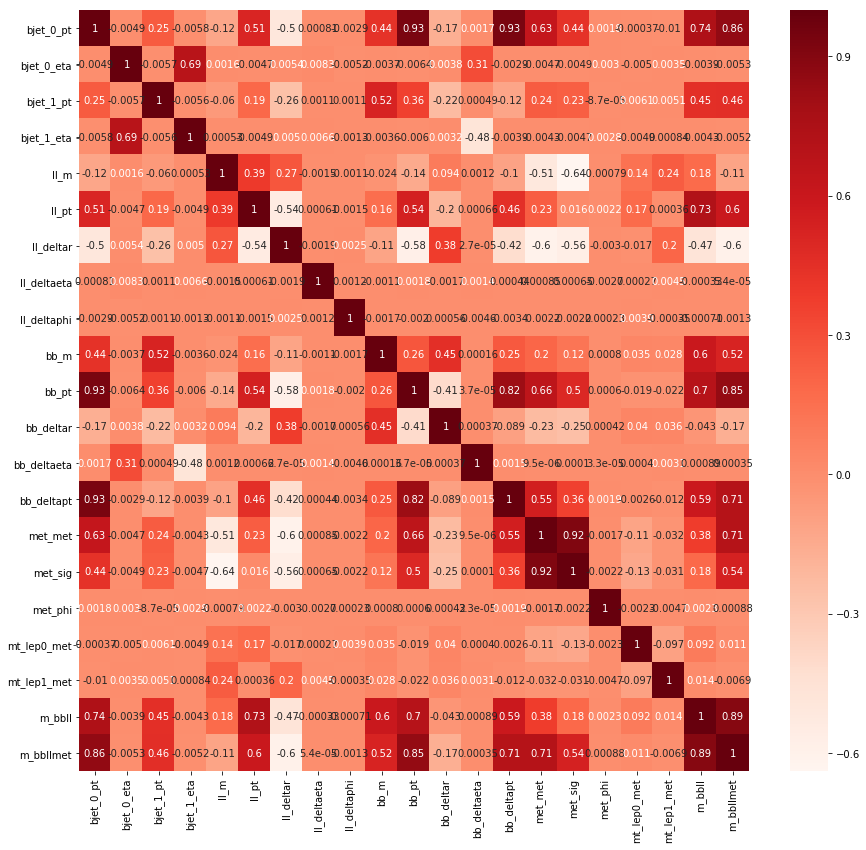

In [7]:
plt.figure(figsize=(15,14))
cor = dataSignal.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

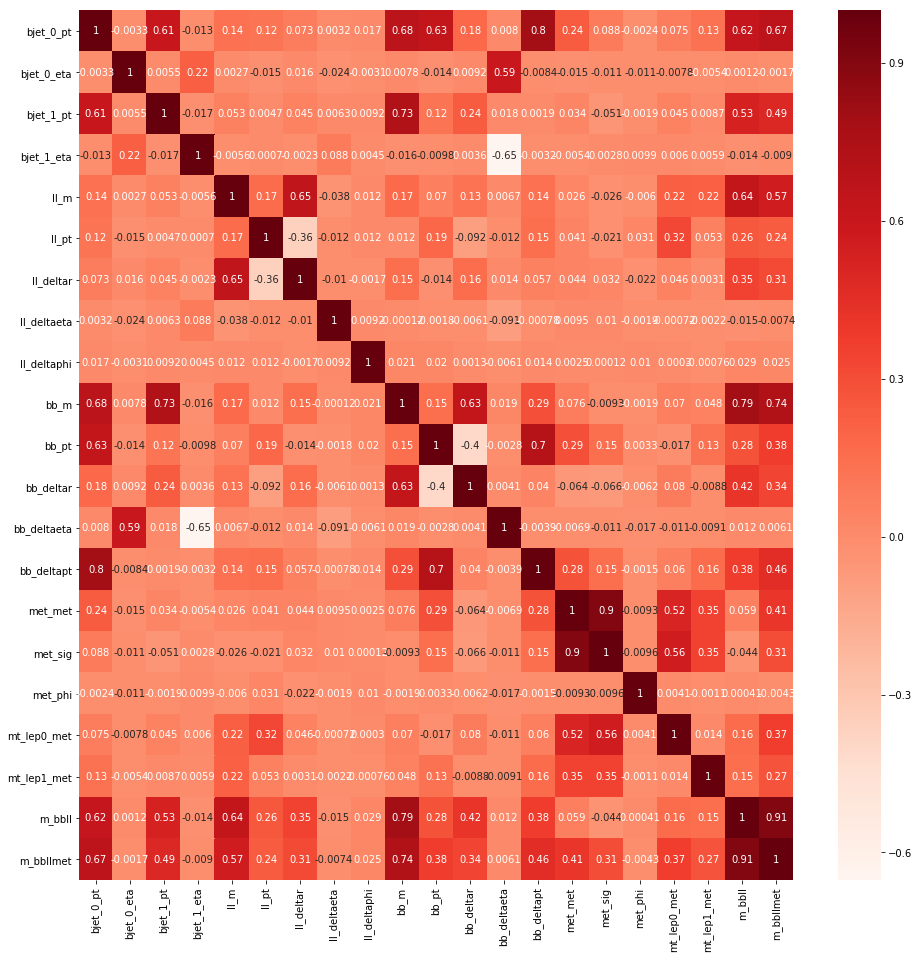

In [8]:
dataBackground=pd.DataFrame(data=backgroundArray[:,1:],columns=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
plt.figure(figsize=(16,16))
cor = dataBackground.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()



In [9]:
print(signalArray)

[[ 5.99125689e-08  3.43779406e+05 -8.89795244e-01 ...  8.16832910e+03
   1.01459575e+06  1.15864900e+06]
 [ 1.37623146e-05  2.02115812e+05 -1.13858283e+00 ...  4.82755898e+04
   4.13342219e+05  5.49812625e+05]
 [ 1.21445784e-06  2.04746391e+05  1.65332592e+00 ...  2.39445947e+03
   4.90221562e+05  9.90220812e+05]
 ...
 [ 3.69084698e-05  9.59073438e+04 -1.60544014e+00 ...  1.28037285e+04
   2.70796531e+05  3.64658312e+05]
 [ 4.55069750e-06  2.05500875e+05  5.38439453e-01 ...  1.36688916e+04
   5.46038250e+05  6.63057375e+05]
 [ 1.65528623e-06  2.39564734e+05 -1.39261913e+00 ...  3.73748608e+03
   4.83871188e+05  1.09625988e+06]]


In [10]:
print(signalArray[:,1])

[343779.40625  202115.8125   204746.390625 ...  95907.34375  205500.875
 239564.734375]


Add signal Region cuts $m_{jj}>300$ Gev and $|\Delta(y_{jj})|>2.0$.

In [11]:
signalSample=signalArray#[(abs(signalArray[:,3])>2.0)&(signalArray[:,1]>300)]
backgroundSample=backgroundArray#[(abs(backgroundArray[:,3])>2.0)&(backgroundArray[:,1]>300)]

In [12]:
print(len(signalSample))
print(len(backgroundSample))

217248
10995


In [13]:
signalNum=len(signalSample)
backgroundNum=len(backgroundSample)
print("signal event number after cut is: ",signalNum)
print("background event number after cut is:",backgroundNum)

signal event number after cut is:  217248
background event number after cut is: 10995


Split datasets into training and testing subsets

In [14]:
trainingRatio=0.9
sigTrainNum=int(signalNum*0.9)
backgroundTrainNum=int(backgroundNum*0.9)
sigTestNum=signalNum-sigTrainNum
backgroundTestNum=backgroundNum-backgroundTrainNum
print("training signal events number is: ",sigTrainNum)
print("testing signal events number is: ",sigTestNum)
print("training background events number is: ",backgroundTrainNum)
print("testing background events number is: ",backgroundTestNum)


training signal events number is:  195523
testing signal events number is:  21725
training background events number is:  9895
testing background events number is:  1100


In [15]:
signal_row=np.arange(0,signalNum-1,1)
background_row=np.arange(0,backgroundNum-1,1)
signal_train_row=np.random.choice(signal_row,size=sigTrainNum,replace=False)
background_train_row=np.random.choice(background_row,size=backgroundTrainNum,replace=False)
label_signal_train=np.ones((sigTrainNum,1))
label_background_train=np.zeros((backgroundTrainNum,1))
label_signal_test=np.ones((sigTestNum,1))
label_background_test=np.zeros((backgroundTestNum,1))
signalTrain=signalSample[signal_train_row,:]
signalTest=np.delete(signalSample,signal_train_row,axis=0)
backgroundTrain=backgroundSample[background_train_row,:]
backgroundTest=np.delete(backgroundSample,background_train_row,axis=0)
signalTrain=np.concatenate((label_signal_train,signalTrain),axis=1)
backgroundTrain=np.concatenate((label_background_train,backgroundTrain),axis=1)
signalTest=np.concatenate((label_signal_test,signalTest),axis=1)
backgroundTest=np.concatenate((label_background_test,backgroundTest),axis=1)
ratio=sum(signalTrain[:,1])/sum(backgroundTrain[:,1])
signalTrain[:,1]=signalTrain[:,1]/ratio
print(backgroundTest)
print(ratio)

[[0.00000000e+00 2.28712529e-02 9.18311641e+04 ... 8.26722891e+04
  3.14942062e+05 4.47353719e+05]
 [0.00000000e+00 3.43414116e-02 1.81585859e+05 ... 2.07334297e+05
  4.67148344e+05 6.32169188e+05]
 [0.00000000e+00 3.15081539e-02 7.79334531e+04 ... 7.57377109e+04
  2.14107391e+05 3.41311969e+05]
 ...
 [0.00000000e+00 7.65462537e-03 1.17313719e+05 ... 8.09033281e+04
  3.79072562e+05 4.42232625e+05]
 [0.00000000e+00 4.17196325e-02 1.21799773e+05 ... 3.08787637e+04
  2.76397625e+05 3.05307438e+05]
 [0.00000000e+00 4.76664438e-02 1.04544781e+05 ... 8.39545000e+04
  2.79220312e+05 3.78958656e+05]]
0.0017894831066004825


In [16]:
dataTrain=np.vstack((signalTrain,backgroundTrain))
dataTest=np.vstack((signalTest,backgroundTest))
np.random.shuffle(dataTrain)
np.random.shuffle(dataTest)
dataTrainLabel=dataTrain[:,0]
dataTrainWeight=dataTrain[:,1]
dataTrainSample=dataTrain[:,2:]
dataTestLabel=dataTest[:,0]
dataTestWeight=dataTest[:,1]
dataTestSample=dataTest[:,2:]
tf.cast(dataTrainLabel,tf.float32)
tf.cast(dataTrainSample,tf.float32)

<tf.Tensor 'Cast_1:0' shape=(205418, 21) dtype=float32>

Signal and background training sets should have same yield in training

(205418,)
(205418,)


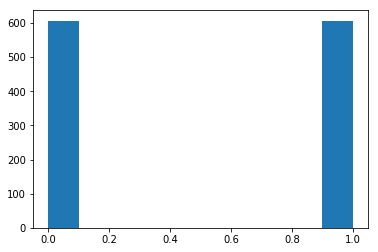

In [17]:
plt.hist(dataTrain[:,0],weights=dataTrainWeight)
print(dataTrainWeight.shape)
dataTrainWeight=dataTrainWeight.transpose()
print(dataTrainWeight.shape)
classweight = {0: 19.75,
                1: 1.}

Build model

In [18]:
traindf=pd.DataFrame(data=dataTrainSample)
normalize_df=(traindf-traindf.min())/(traindf.max()-traindf.min())
dataTrainSample1=normalize_df.values
print(dataTrainSample1)

[[6.12290152e-02 6.44406387e-01 4.26423241e-04 ... 4.67407633e-02
  3.43976547e-02 4.42066898e-02]
 [4.83083440e-02 6.91966997e-01 6.11459686e-02 ... 7.86232951e-02
  3.47589851e-02 6.99317903e-02]
 [1.43203297e-01 5.15127124e-01 2.89840005e-02 ... 1.08265767e-01
  1.21941452e-01 1.14450130e-01]
 ...
 [3.35514109e-01 3.73155676e-01 7.47612836e-03 ... 7.49124727e-03
  2.20151891e-01 2.44652265e-01]
 [1.00866036e-01 2.01012984e-01 1.27504494e-01 ... 8.77915413e-02
  8.04801245e-02 1.49809313e-01]
 [2.18193241e-02 9.62578760e-01 5.05478488e-03 ... 3.00686805e-02
  3.24249763e-02 2.72172374e-02]]


In [19]:
model = Sequential()
model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu",
    input_dim=21))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))

# Set loss, optimizer and evaluation metrics
model.compile(
     loss="binary_crossentropy",
     #optimizer=Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
      optimizer='adam',
     metrics=["acc"])

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='acc',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')

In [21]:
model.save('model_HHtt.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               6600      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_4 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_5 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_6 (Dense)              (None, 300)               90300     
__________

2019-06-21 01:24:11.885833: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2019-06-21 01:24:11.889172: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3600000000 Hz
2019-06-21 01:24:11.889692: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x556d011a5510 executing computations on platform Host. Devices:
2019-06-21 01:24:11.889707: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-06-21 01:24:11.951071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-06-21 01:24:11.951396: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x556d012545d0 executing computations on platform CUDA. Devices:
2019-06-21 01:24:11.951410: I t

In [22]:
model.fit(dataTrainSample1,dataTrainLabel,batch_size=50, epochs=30,
          sample_weight=dataTrainWeight,
          callbacks=[early_stopping])

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
205418/205418 [==============================] - 24s 117us/sample - loss: 0.3164 - acc: 0.9517
Epoch 2/30
205418/205418 [==============================] - 26s 126us/sample - loss: 0.2434 - acc: 0.9637
Epoch 3/30
205418/205418 [==============================] - 24s 116us/sample - loss: 0.2220 - acc: 0.9691
Epoch 4/30
205418/205418 [==============================] - 26s 125us/sample - loss: 0.2054 - acc: 0.9727
Epoch 5/30
205418/205418 [==============================] - 25s 119us/sample - loss: 0.2049 - acc: 0.9688
Epoch 6/30
205418/205418 [==============================] - 25s 120us/sample - loss: 0.2018 - acc: 0.9716
Epoch 7/30
205418/205418 [==============================] - 23s 114us/sample - loss: 0.2523 - acc: 0.9642
Epoch 8/30
205418/205418 [==============================] - 23s 111us/sample - loss: 0.1848 - acc: 0.9746
Epoch 9/30
205418/205418 [==============================] - 22s 105us/sample - loss: 0.2441 - acc: 0.974

2019-06-21 01:24:15.346526: I tensorflow/stream_executor/dso_loader.cc:152] successfully opened CUDA library libcublas.so.10.0 locally


In [23]:
signaldf=pd.DataFrame(data=signalSample[:,1:])
normalize_df=(signaldf-signaldf.min())/(signaldf.max()-signaldf.min())
signalSample1=normalize_df.values
print(dataTrainSample1)
backgrounddf=pd.DataFrame(data=backgroundSample[:,1:])
normalize_df=(backgrounddf-backgrounddf.min())/(backgrounddf.max()-backgrounddf.min())
backgroundSample1=normalize_df.values
print(backgroundSample1)

[[6.12290152e-02 6.44406387e-01 4.26423241e-04 ... 4.67407633e-02
  3.43976547e-02 4.42066898e-02]
 [4.83083440e-02 6.91966997e-01 6.11459686e-02 ... 7.86232951e-02
  3.47589851e-02 6.99317903e-02]
 [1.43203297e-01 5.15127124e-01 2.89840005e-02 ... 1.08265767e-01
  1.21941452e-01 1.14450130e-01]
 ...
 [3.35514109e-01 3.73155676e-01 7.47612836e-03 ... 7.49124727e-03
  2.20151891e-01 2.44652265e-01]
 [1.00866036e-01 2.01012984e-01 1.27504494e-01 ... 8.77915413e-02
  8.04801245e-02 1.49809313e-01]
 [2.18193241e-02 9.62578760e-01 5.05478488e-03 ... 3.00686805e-02
  3.24249763e-02 2.72172374e-02]]
[[0.1048238  0.50330782 0.08915562 ... 0.0885143  0.09467147 0.07783742]
 [0.19377055 0.29564217 0.24111472 ... 0.3229771  0.30668546 0.2640282 ]
 [0.04893508 0.73308935 0.04601364 ... 0.19212414 0.05945254 0.06798196]
 ...
 [0.13033736 0.76843606 0.00194335 ... 0.03767111 0.22142912 0.16110338]
 [0.0810195  0.34781338 0.04074328 ... 0.05596303 0.1327359  0.10465274]
 [0.09606173 0.32056755 0.1405

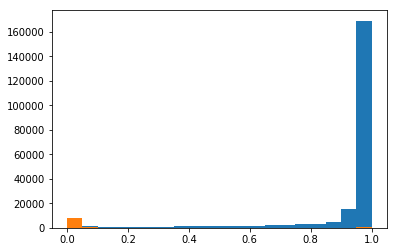

In [24]:
signalNN=model.predict(signalSample1)
backgroundNN=model.predict(backgroundSample1)
plt.hist(signalNN,bins=20)
plt.hist(backgroundNN,bins=20)
NNTrainScore=model.predict(dataTrainSample1)

(array([8401.,  329.,  183.,  127.,  129.,  100.,   96.,   97.,   75.,
          78.,   86.,   92.,   68.,   71.,   76.,   75.,   76.,   86.,
         198.,  552.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

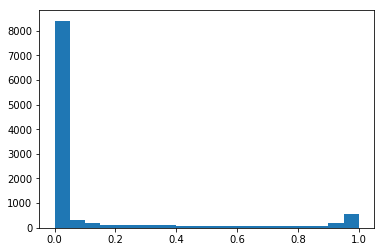

In [25]:
backgroundNN=model.predict(backgroundSample1)
plt.hist(backgroundNN,bins=20)

Save NN model to h5 file

In [26]:
model.save('model_4lHHtt.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               6600      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_4 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_5 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_6 (Dense)              (None, 300)               90300     
__________

In [28]:
signalNNScore=model.predict(signalSample1)
#backgroundNNScore=model.predict(backgroundArray[:,1:])
print(signalNNScore)

[[1.        ]
 [0.9500396 ]
 [1.        ]
 ...
 [0.73657054]
 [0.96542704]
 [1.        ]]


(array([  2281.,   1180.,   1023.,    932.,    946.,    982.,   1018.,
          1107.,   1209.,   1329.,   1621.,   1771.,   1748.,   2116.,
          2561.,   2976.,   3453.,   4815.,  15202., 168978.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

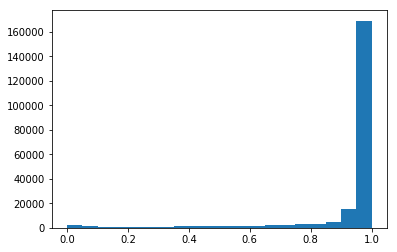

In [29]:
plt.hist(signalNNScore,bins=20)

In [30]:
cuda.select_device(0)
cuda.close()

In [31]:
varName=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"]
BDTtrain=xgb.DMatrix(dataTrainSample,label=dataTrainLabel,weight=dataTrainWeight,feature_names=varName)
BDTtest=xgb.DMatrix(dataTestSample,label=dataTestLabel,weight=dataTestWeight,feature_names=varName)
BDTSignal=xgb.DMatrix(signalArray[:,1:],feature_names=varName)
BDTBackground=xgb.DMatrix(backgroundArray[:,1:],feature_names=varName)
param = {'max_depth': 7, 'eta': 0.6, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 16
param['eval_metric'] = 'auc'
param['tree_method'] = 'gpu_hist'
param['grow_policy'] = 'depthwise'
param['subsample']=0.9
evallist = [(BDTtest, 'eval'), (BDTtrain, 'train')]

/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndar

In [32]:
num_round = 1000
GBDT = xgb.train(param, BDTtrain, num_round, evallist)

[0]	eval-auc:0.953825	train-auc:0.965669
[1]	eval-auc:0.967843	train-auc:0.976306
[2]	eval-auc:0.975535	train-auc:0.981885
[3]	eval-auc:0.978162	train-auc:0.985403
[4]	eval-auc:0.979503	train-auc:0.987624
[5]	eval-auc:0.979684	train-auc:0.98852
[6]	eval-auc:0.980369	train-auc:0.989874
[7]	eval-auc:0.981617	train-auc:0.99031
[8]	eval-auc:0.981938	train-auc:0.991435
[9]	eval-auc:0.982308	train-auc:0.992219
[10]	eval-auc:0.982468	train-auc:0.992885
[11]	eval-auc:0.981919	train-auc:0.993597
[12]	eval-auc:0.9824	train-auc:0.994008
[13]	eval-auc:0.982085	train-auc:0.994461
[14]	eval-auc:0.983013	train-auc:0.994975
[15]	eval-auc:0.983158	train-auc:0.995338
[16]	eval-auc:0.983212	train-auc:0.995646
[17]	eval-auc:0.983167	train-auc:0.995946
[18]	eval-auc:0.983306	train-auc:0.996288
[19]	eval-auc:0.98301	train-auc:0.996604
[20]	eval-auc:0.983071	train-auc:0.996953
[21]	eval-auc:0.983364	train-auc:0.997296
[22]	eval-auc:0.983232	train-auc:0.997697
[23]	eval-auc:0.982916	train-auc:0.998048
[24]	ev

[198]	eval-auc:0.97664	train-auc:1.00852
[199]	eval-auc:0.976536	train-auc:1.00854
[200]	eval-auc:0.976749	train-auc:1.00852
[201]	eval-auc:0.976563	train-auc:1.00856
[202]	eval-auc:0.976612	train-auc:1.00856
[203]	eval-auc:0.976593	train-auc:1.00859
[204]	eval-auc:0.976301	train-auc:1.00862
[205]	eval-auc:0.976137	train-auc:1.0086
[206]	eval-auc:0.976196	train-auc:1.00867
[207]	eval-auc:0.976239	train-auc:1.00867
[208]	eval-auc:0.976166	train-auc:1.0087
[209]	eval-auc:0.976207	train-auc:1.00873
[210]	eval-auc:0.976112	train-auc:1.00879
[211]	eval-auc:0.975927	train-auc:1.00884
[212]	eval-auc:0.975762	train-auc:1.00889
[213]	eval-auc:0.975852	train-auc:1.00894
[214]	eval-auc:0.97574	train-auc:1.00899
[215]	eval-auc:0.975376	train-auc:1.00904
[216]	eval-auc:0.975402	train-auc:1.0091
[217]	eval-auc:0.975695	train-auc:1.00914
[218]	eval-auc:0.975841	train-auc:1.00917
[219]	eval-auc:0.976237	train-auc:1.00916
[220]	eval-auc:0.976224	train-auc:1.00921
[221]	eval-auc:0.975943	train-auc:1.009

[395]	eval-auc:0.972378	train-auc:1.01188
[396]	eval-auc:0.972202	train-auc:1.01187
[397]	eval-auc:0.97244	train-auc:1.01186
[398]	eval-auc:0.972571	train-auc:1.01187
[399]	eval-auc:0.972366	train-auc:1.01188
[400]	eval-auc:0.972156	train-auc:1.01188
[401]	eval-auc:0.972117	train-auc:1.01185
[402]	eval-auc:0.972196	train-auc:1.01186
[403]	eval-auc:0.972292	train-auc:1.01188
[404]	eval-auc:0.972294	train-auc:1.01191
[405]	eval-auc:0.972316	train-auc:1.01191
[406]	eval-auc:0.972568	train-auc:1.01191
[407]	eval-auc:0.972284	train-auc:1.01193
[408]	eval-auc:0.972415	train-auc:1.01198
[409]	eval-auc:0.972286	train-auc:1.01198
[410]	eval-auc:0.972116	train-auc:1.012
[411]	eval-auc:0.972101	train-auc:1.01202
[412]	eval-auc:0.971863	train-auc:1.01197
[413]	eval-auc:0.971898	train-auc:1.01196
[414]	eval-auc:0.972052	train-auc:1.01197
[415]	eval-auc:0.972209	train-auc:1.01198
[416]	eval-auc:0.972176	train-auc:1.012
[417]	eval-auc:0.972218	train-auc:1.01198
[418]	eval-auc:0.971974	train-auc:1.011

[592]	eval-auc:0.969629	train-auc:1.01263
[593]	eval-auc:0.96987	train-auc:1.01262
[594]	eval-auc:0.969586	train-auc:1.01264
[595]	eval-auc:0.969663	train-auc:1.01264
[596]	eval-auc:0.969508	train-auc:1.01261
[597]	eval-auc:0.968681	train-auc:1.01261
[598]	eval-auc:0.968967	train-auc:1.01265
[599]	eval-auc:0.969232	train-auc:1.01265
[600]	eval-auc:0.969177	train-auc:1.01267
[601]	eval-auc:0.969014	train-auc:1.01273
[602]	eval-auc:0.969121	train-auc:1.01277
[603]	eval-auc:0.969058	train-auc:1.01275
[604]	eval-auc:0.969146	train-auc:1.01276
[605]	eval-auc:0.969063	train-auc:1.01271
[606]	eval-auc:0.969137	train-auc:1.01273
[607]	eval-auc:0.96918	train-auc:1.01275
[608]	eval-auc:0.969197	train-auc:1.01273
[609]	eval-auc:0.969107	train-auc:1.01274
[610]	eval-auc:0.968695	train-auc:1.01269
[611]	eval-auc:0.968727	train-auc:1.0127
[612]	eval-auc:0.968724	train-auc:1.01275
[613]	eval-auc:0.968505	train-auc:1.01274
[614]	eval-auc:0.96859	train-auc:1.01276
[615]	eval-auc:0.968671	train-auc:1.01

[789]	eval-auc:0.965986	train-auc:1.01324
[790]	eval-auc:0.965845	train-auc:1.01323
[791]	eval-auc:0.965971	train-auc:1.01322
[792]	eval-auc:0.966122	train-auc:1.01322
[793]	eval-auc:0.965705	train-auc:1.0132
[794]	eval-auc:0.965823	train-auc:1.01322
[795]	eval-auc:0.965758	train-auc:1.01323
[796]	eval-auc:0.965543	train-auc:1.01319
[797]	eval-auc:0.965805	train-auc:1.0132
[798]	eval-auc:0.9658	train-auc:1.01321
[799]	eval-auc:0.965871	train-auc:1.01318
[800]	eval-auc:0.965893	train-auc:1.01317
[801]	eval-auc:0.966007	train-auc:1.01318
[802]	eval-auc:0.966293	train-auc:1.01321
[803]	eval-auc:0.966002	train-auc:1.0132
[804]	eval-auc:0.966262	train-auc:1.01324
[805]	eval-auc:0.965992	train-auc:1.0132
[806]	eval-auc:0.965949	train-auc:1.01319
[807]	eval-auc:0.966059	train-auc:1.01322
[808]	eval-auc:0.966028	train-auc:1.01321
[809]	eval-auc:0.965906	train-auc:1.01318
[810]	eval-auc:0.965997	train-auc:1.01321
[811]	eval-auc:0.965996	train-auc:1.01322
[812]	eval-auc:0.965962	train-auc:1.0131

[986]	eval-auc:0.963844	train-auc:1.01349
[987]	eval-auc:0.963732	train-auc:1.01349
[988]	eval-auc:0.963827	train-auc:1.01345
[989]	eval-auc:0.96376	train-auc:1.01341
[990]	eval-auc:0.963794	train-auc:1.01344
[991]	eval-auc:0.963501	train-auc:1.01344
[992]	eval-auc:0.963318	train-auc:1.01345
[993]	eval-auc:0.963583	train-auc:1.01346
[994]	eval-auc:0.963706	train-auc:1.01348
[995]	eval-auc:0.963431	train-auc:1.01346
[996]	eval-auc:0.963341	train-auc:1.01349
[997]	eval-auc:0.963244	train-auc:1.01344
[998]	eval-auc:0.963394	train-auc:1.01345
[999]	eval-auc:0.961911	train-auc:1.01344


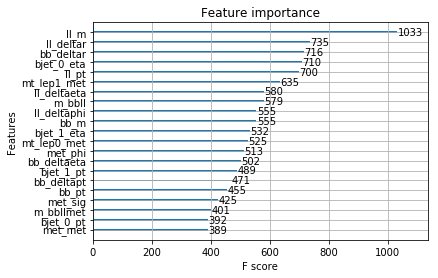

In [33]:
xgb.plot_importance(GBDT)

(array([9823.,  218.,  133.,   98.,   61.,   66.,   50.,   45.,   47.,
          33.,   36.,   36.,   23.,   22.,   24.,   25.,   27.,   23.,
          25.,  180.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

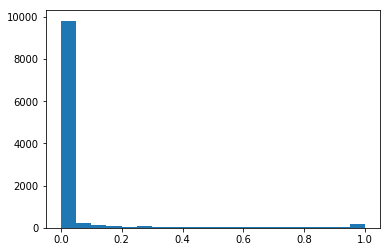

In [34]:
SignalScore=GBDT.predict(BDTSignal)
#plt.hist(SignalScore,bins=20)
BackgroundScore=GBDT.predict(BDTBackground)
plt.hist(BackgroundScore,bins=20)

(array([2.57800e+03, 3.42000e+02, 2.53000e+02, 2.23000e+02, 1.74000e+02,
        1.82000e+02, 1.51000e+02, 1.74000e+02, 1.92000e+02, 1.57000e+02,
        1.70000e+02, 1.88000e+02, 1.86000e+02, 2.26000e+02, 2.51000e+02,
        2.85000e+02, 3.24000e+02, 4.70000e+02, 8.36000e+02, 2.09886e+05]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

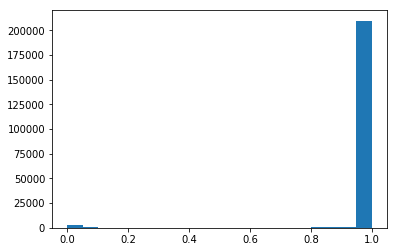

In [35]:
plt.hist(SignalScore,bins=20)

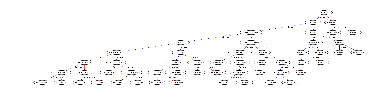

In [36]:
plot_tree(GBDT, num_trees=4)

(array([1.11290e+04, 5.05000e+02, 3.51000e+02, 2.98000e+02, 2.13000e+02,
        2.23000e+02, 1.81000e+02, 1.91000e+02, 2.16000e+02, 1.75000e+02,
        1.90000e+02, 2.07000e+02, 1.82000e+02, 2.23000e+02, 2.56000e+02,
        2.90000e+02, 3.18000e+02, 4.56000e+02, 7.82000e+02, 1.89032e+05]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

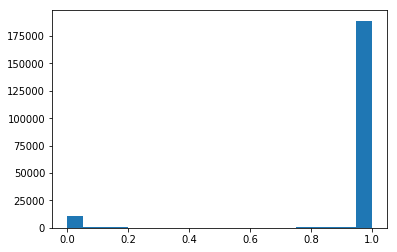

In [37]:
trainScore=GBDT.predict(BDTtrain)
testScore=GBDT.predict(BDTtest)
plt.hist(trainScore,bins=20)

In [38]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,trainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)

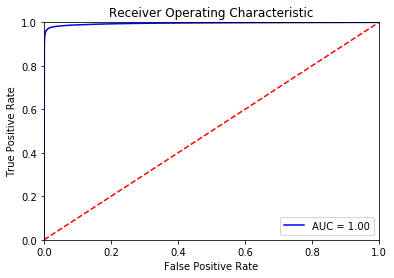

In [39]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

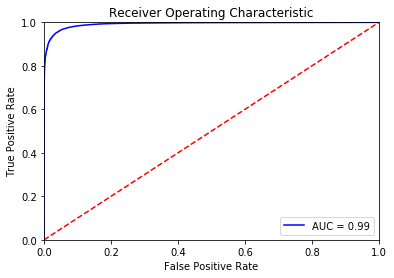

In [40]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,NNTrainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [41]:
pickle.dump(GBDT, open("GBDT_HHtt.pickle.dat", "wb"))

In [42]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTestLabel,testScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)

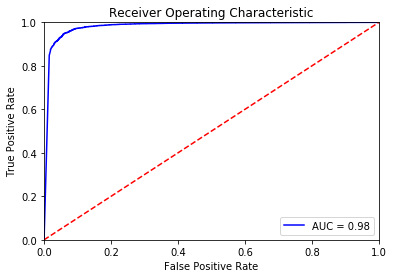

In [43]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()